In [141]:
from src.regression.pre_process import *
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [142]:
# Regression Training
X_train, X_test, y_train, y_test = processRegressionTrain('./data/TrainDataset2024.xls')

Epoch [1/10] - Train Loss: 3277.8250 - Validation Loss: 3316.8180
Epoch [2/10] - Train Loss: 2228.3245 - Validation Loss: 2294.3917
Epoch [3/10] - Train Loss: 1196.4386 - Validation Loss: 1391.0050
Epoch [4/10] - Train Loss: 643.0805 - Validation Loss: 1114.7358
Epoch [5/10] - Train Loss: 517.6788 - Validation Loss: 714.2625
Epoch [6/10] - Train Loss: 465.4164 - Validation Loss: 734.4372
Epoch [7/10] - Train Loss: 460.0084 - Validation Loss: 872.4011
Epoch [8/10] - Train Loss: 435.5156 - Validation Loss: 761.3719
Epoch [9/10] - Train Loss: 453.5091 - Validation Loss: 723.5151
Epoch [10/10] - Train Loss: 460.3190 - Validation Loss: 443.1481


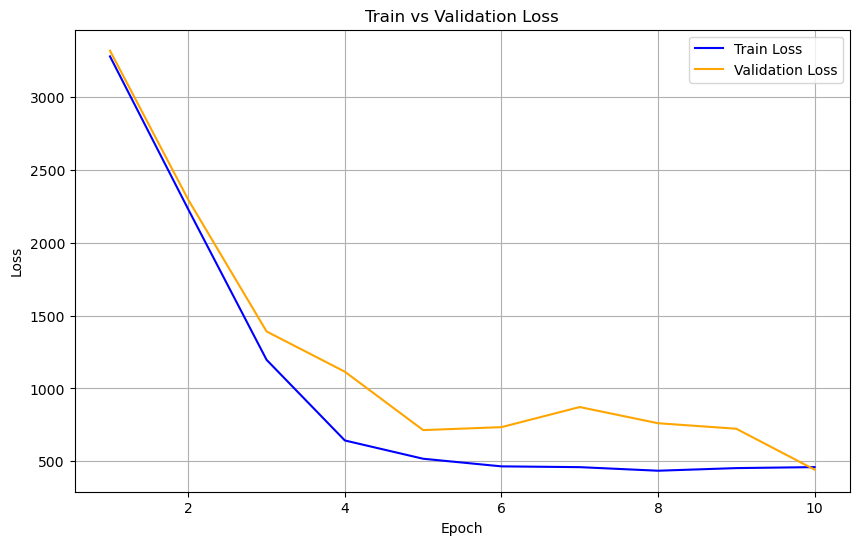

Mean Squared Error: 422.01285764050243
Mean Absolute Error: 18.963099908828735
R2 Score: 0.4711303521945198


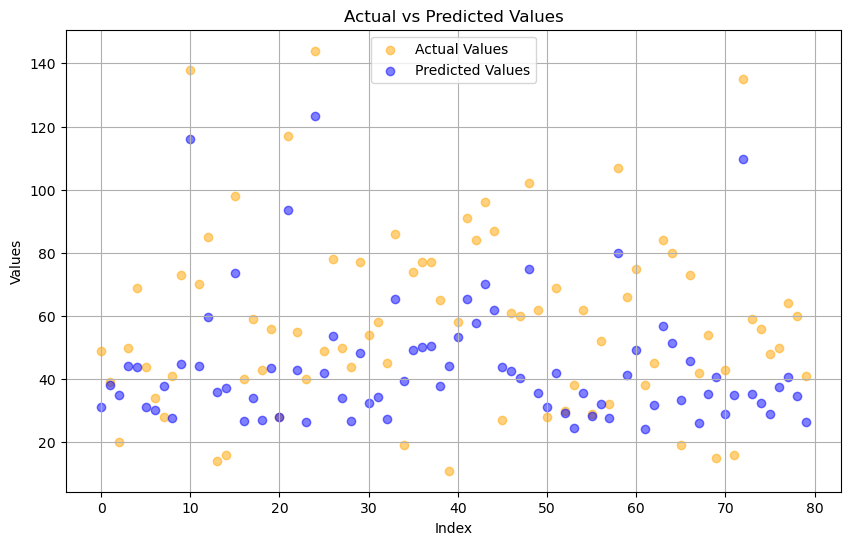

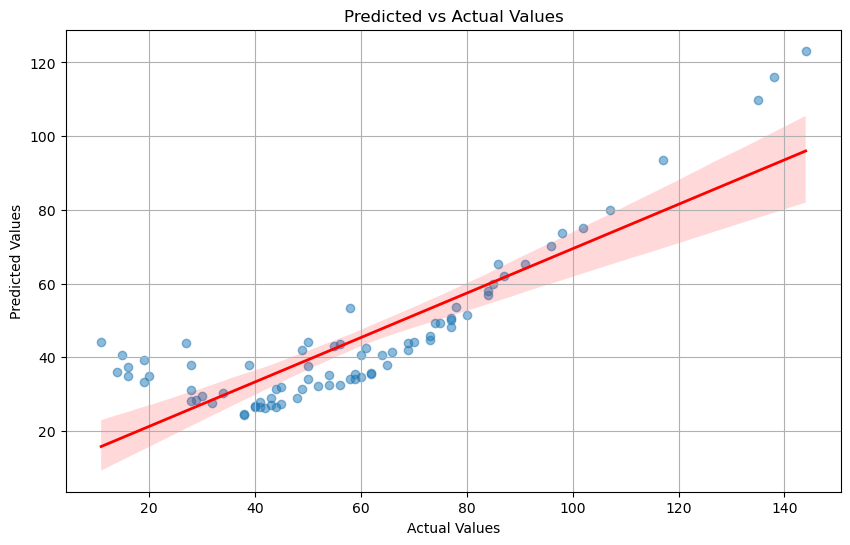

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Split the training data into training and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Convert numpy arrays to tensors
X_train_tensor = torch.from_numpy(X_train_sub.to_numpy()).float()
X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
X_test_tensor = torch.from_numpy(X_test.to_numpy()).float()
y_train_tensor = torch.from_numpy(y_train_sub.to_numpy()).float().view(-1, 1)
y_val_tensor = torch.from_numpy(y_val.to_numpy()).float().view(-1, 1)
y_test_tensor = torch.from_numpy(y_test.to_numpy()).float().view(-1, 1)

# Define the neural network model with adjustments for complexity
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Increased number of neurons
        self.bn1 = nn.BatchNorm1d(512)        # Batch Normalization
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 1)         # Regression output

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  # Apply BatchNorm + ReLU
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # Final layer with no activation for regression
        return x

net = Net(input_size=X_train_tensor.shape[1])

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Training parameters
epochs = 10  # Increased epochs for better learning
batch_size = 2  # Use mini-batches to stabilize training

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

# Train the network
for epoch in range(epochs):
    net.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            val_outputs = net(batch_X)
            loss = criterion(val_outputs, batch_y)
            val_loss += loss.item()

    # Learning rate scheduler
    scheduler.step(val_loss)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    # Early stopping (optional)
    if epoch > 10 and val_loss > min(val_losses[-10:]):
        print(f"Stopping early at epoch {epoch+1} due to no improvement in validation loss.")
        break

# Plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
net.eval()
with torch.no_grad():
    y_pred_tensor = net(X_test_tensor)
    y_pred = y_pred_tensor.detach().cpu().numpy()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Plotting the difference between actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual Values", color="orange", alpha=0.5)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted Values", color="blue", alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.legend()
plt.show()

# Plotting Predicted vs Actual Values
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red", "lw": 2}, scatter_kws={"alpha": 0.5})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()

# Save the model
os.makedirs('./src/models/regression', exist_ok=True)
torch.save(net.state_dict(), './src/models/regression/dnn_model.pth')

In [144]:
import pandas as pd
import torch

def predict_with_dnn(test_file_path, model_path, scaler_path):
    """
    Load the trained DNN model and make predictions on the test data.

    Parameters:
    test_file_path : str
        Path to the test dataset file.
    model_path : str
        Path to the saved DNN model.

    Returns:
    pd.DataFrame
        DataFrame containing IDs and predicted values.
    """

    # Read original data to get IDs
    original_data = pd.read_excel(test_file_path)
    original_ids = original_data['ID'].values

    # Load the test data
    _, X_test, _, y_test = processRegressionTest(test_file_path)

    # Convert test data to tensor
    X_test_tensor = torch.from_numpy(X_test.to_numpy()).float()

    # Load the saved DNN model
    model = Net(input_size=X_test_tensor.shape[1])
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    # Make predictions
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.detach().cpu().numpy().flatten()

    # Create results DataFrame
    results = pd.DataFrame({
        'ID': original_ids,
        'Predicted RelapseFreeSurvival (outcome)': y_pred.squeeze()
    })

    return results

# Example usage
predictions_df = predict_with_dnn('./data/FinalTestDataset2024.xls', './src/models/regression/dnn_model.pth', './src/models/data_preprocessing/regression/scaler.joblib')
print("\nPredictions on Test Data:")
print(predictions_df)


Predictions on Test Data:
            ID  Predicted RelapseFreeSurvival (outcome)
0    TRG002219                                47.801006
1    TRG002222                                48.072308
2    TRG002223                                46.019932
3    TRG002235                                46.112484
4    TRG002240                                47.460335
..         ...                                      ...
128  TRG002953                                47.047791
129  TRG002955                                47.495377
130  TRG002956                                46.160271
131  TRG002957                                45.444473
132  TRG002963                                46.474823

[133 rows x 2 columns]


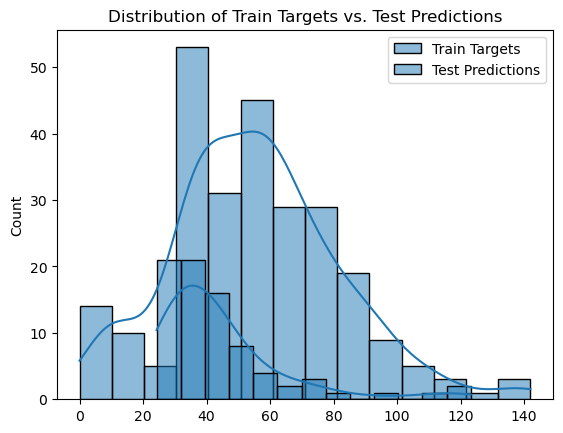

In [145]:
import seaborn as sns

# Example: Plot distributions
sns.histplot(y_train_tensor.numpy(), label="Train Targets", kde=True, color="blue")
sns.histplot(y_pred, label="Test Predictions", kde=True, color="orange")
plt.legend()
plt.title("Distribution of Train Targets vs. Test Predictions")
plt.show()